# Explaining MobileNet V2 With Saliency Maps




MobileNet is a model built by Google that is optimized for image classification on edge devices like phones and tablets. In this study I would like to explore if and how data augmentation changes the performance and decision making process in classifying objects for a model like MobileNet. MobileNet V2 was selected as it is a solid overall choice when compared to the different version of MobileNet that exist and it works best for general applications such as this study.

**Null Hypothesis $H_{0}$**: MobileNet's accuracy and decision making process has no effect when trained on the CIFAR-10 dataset after performing data augmentations to introduce variability in the dataset.

**Alternative Hypothesis $H_{1}$**: MobileNet's accuracy is significantly improved when trained on the CIFAR-10 dataset and augmenting training data by observing the feature importance based on the saliency maps generated by the model.

## Approach

1. As a control group, train an instance of the MobileNet V3 model on the CIFAR-10 dataset without performing any augmentations and assessing the accuracy of the model and the saliency maps to see which features contributed to its prediction

2. Then use the same dataset and perform augmentations such as random rotations and flips and retrain the model and assess its accuracy at this stage along with its saliency maps to determine if the model was able to find important features in an image.

3. Compare and analyze results to determine the effect of data augmentation on MobileNet

### Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2
import numpy as np
import matplotlib.pyplot as plt
import random

### Control Model Implementation

Set up the control dataset for the initial model

In [2]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # Resize to fit MobileNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:04<00:00, 37931948.27it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Use the MobileNet V2 version that Pytorch provides

In [3]:
model = mobilenet_v2(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

A portion of the training code was AI generated

In [4]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(train_loader), correct / total

def validate(model, test_loader, criterion, device):
    model.eval()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(test_loader), correct / total

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}]: '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/10]: Train Loss: 1.9340, Train Accuracy: 0.2708, Validation Loss: 1.6461, Validation Accuracy: 0.3881
Epoch [2/10]: Train Loss: 1.5734, Train Accuracy: 0.4186, Validation Loss: 1.4787, Validation Accuracy: 0.4575
Epoch [3/10]: Train Loss: 1.4126, Train Accuracy: 0.4827, Validation Loss: 1.3482, Validation Accuracy: 0.5119
Epoch [4/10]: Train Loss: 1.2792, Train Accuracy: 0.5399, Validation Loss: 1.2548, Validation Accuracy: 0.5461
Epoch [5/10]: Train Loss: 1.1588, Train Accuracy: 0.5846, Validation Loss: 1.1795, Validation Accuracy: 0.5756
Epoch [6/10]: Train Loss: 1.0494, Train Accuracy: 0.6264, Validation Loss: 1.1370, Validation Accuracy: 0.5911
Epoch [7/10]: Train Loss: 0.9489, Train Accuracy: 0.6628, Validation Loss: 1.0992, Validation Accuracy: 0.6094
Epoch [8/10]: Train Loss: 0.8550, Train Accuracy: 0.6975, Validation Loss: 1.1118, Validation Accuracy: 0.6183
Epoch [9/10]: Train Loss: 0.7662, Train Accuracy: 0.7308, Validation Loss: 1.1167, Validation Accuracy: 0.6176
E

Generate the Saliency maps for control group

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2352166..1.4866874].


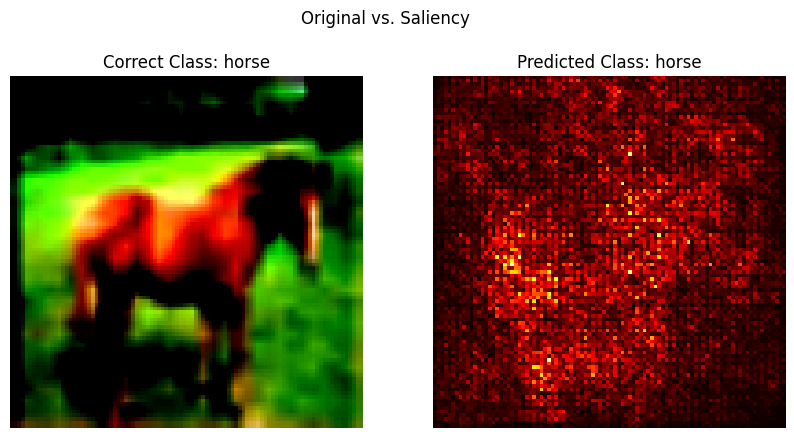

In [23]:
def compute_saliency_map(model, images, labels, device):
    model.eval()
    images.requires_grad_()

    images = images.to(device)
    labels = labels.to(device)

    predictions = model(images)

    loss = F.cross_entropy(predictions, labels)

    model.zero_grad()
    loss.backward()

    grads = images.grad.abs()

    saliency = torch.max(grads, dim=1)[0].cpu().numpy()

    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))
    
    return saliency

for images, labels in test_loader:
    index = random.randint(0, 64)
    image = images[index].unsqueeze(0)  
    label = labels[index]
    break

image = image.to(device)
label = label.unsqueeze(0).to(device)
with torch.no_grad():
    prediction = model(image)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Compute the saliency map
saliency_map = compute_saliency_map(model, image, label, device)

# Visualization
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.suptitle("Original vs. Saliency")
plt.imshow(np.transpose(image[0].detach().cpu().numpy(), (1, 2, 0)))  # Convert CHW to HWC format
plt.title(f"Correct Class: {class_names[label.item()]}")
plt.axis('off')

# Saliency map
plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency_map[0], cmap='hot')  # Display the first channel of the saliency map
plt.title(f"Predicted Class: {class_names[np.argmax(prediction.cpu().numpy(), axis=1)[0]]}")
plt.axis('off')

plt.show()

**Analysis**

In the plots above, saliency maps are generated for predictions that the model makes after being trained on the CIFAR-10 dataset. This control model with no augmentation had around a 60% accuracy which is quite poor and the saliency maps reflect that, as the previous cell is ran multiple times, it picks out random input images and makes predictions on it and creates a saliency map.

The red portions of the saliency map shows increased importance in those pixels and if you run the previous cell multiple times it is clear to see why. A lot of the predictions have random noise and it's unclear how the model makes decisions but the poor performance is certainly understandable and the model is unable to generalize this dataset well.

It is also important to note that the training process had quite a low validation accuracy which shows that the model seems to be overfitting which is important to consider. This model expects inputs of (224, 224) normally but CIFAR-10 is (32, 32) and I have scaled the inputs to (96, 96) in resolution which could contribute to poor performance and unstable training in general.

### Data Augmented Model Implementation

Now we can add random transformations to the dataset and train once again and assess the performance

In [10]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

train_dataset = datasets.CIFAR10(root='./augmented_data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./augmented_data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Create another instance of the MobileNet V2 model

In [7]:
model = mobilenet_v2(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Train the model with random transformation to augment the dataset

In [11]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(train_loader), correct / total

def validate(model, test_loader, criterion, device):
    model.eval()  
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(test_loader), correct / total

# Training the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}]: '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/10]: Train Loss: 1.2441, Train Accuracy: 0.5547, Validation Loss: 1.1830, Validation Accuracy: 0.5746
Epoch [2/10]: Train Loss: 1.1597, Train Accuracy: 0.5819, Validation Loss: 1.1192, Validation Accuracy: 0.5980
Epoch [3/10]: Train Loss: 1.1051, Train Accuracy: 0.6034, Validation Loss: 1.1050, Validation Accuracy: 0.6064
Epoch [4/10]: Train Loss: 1.0554, Train Accuracy: 0.6219, Validation Loss: 1.0532, Validation Accuracy: 0.6246
Epoch [5/10]: Train Loss: 1.0084, Train Accuracy: 0.6391, Validation Loss: 1.0199, Validation Accuracy: 0.6378
Epoch [6/10]: Train Loss: 0.9666, Train Accuracy: 0.6540, Validation Loss: 0.9889, Validation Accuracy: 0.6494
Epoch [7/10]: Train Loss: 0.9305, Train Accuracy: 0.6676, Validation Loss: 0.9722, Validation Accuracy: 0.6539
Epoch [8/10]: Train Loss: 0.8952, Train Accuracy: 0.6831, Validation Loss: 0.9375, Validation Accuracy: 0.6714
Epoch [9/10]: Train Loss: 0.8626, Train Accuracy: 0.6922, Validation Loss: 0.9265, Validation Accuracy: 0.6719
E

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1035852..2.518123].


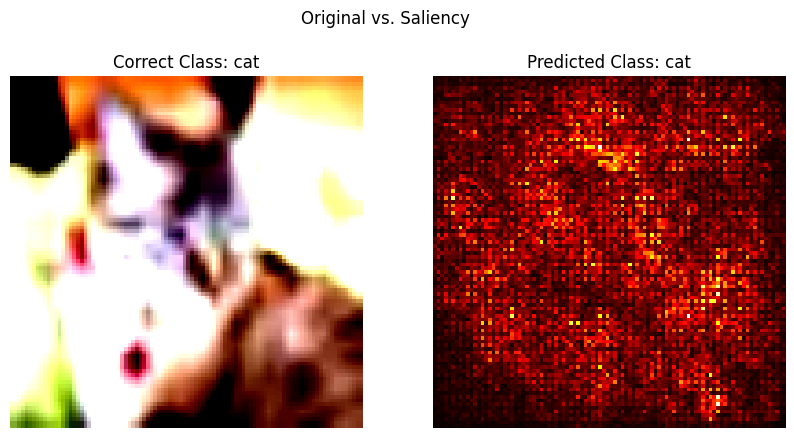

In [27]:
def compute_saliency_map(model, images, labels, device):
    model.eval()
    images.requires_grad_()

    images = images.to(device)
    labels = labels.to(device)

    predictions = model(images)

    loss = F.cross_entropy(predictions, labels)

    model.zero_grad()
    loss.backward()

    grads = images.grad.abs()

    saliency = torch.max(grads, dim=1)[0].cpu().numpy()

    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency))
    
    return saliency

for images, labels in test_loader:
    index = random.randint(0, 64)
    image = images[index].unsqueeze(0)  
    label = labels[index]
    break

image = image.to(device)
label = label.unsqueeze(0).to(device)
with torch.no_grad():
    prediction = model(image)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Compute the saliency map
saliency_map = compute_saliency_map(model, image, label, device)

# Visualization
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.suptitle("Original vs. Saliency")
plt.imshow(np.transpose(image[0].detach().cpu().numpy(), (1, 2, 0)))  # Convert CHW to HWC format
plt.title(f"Correct Class: {class_names[label.item()]}")
plt.axis('off')

# Saliency map
plt.subplot(1, 2, 2)
plt.title("Saliency Map")
plt.imshow(saliency_map[0], cmap='hot')  # Display the first channel of the saliency map
plt.title(f"Predicted Class: {class_names[np.argmax(prediction.cpu().numpy(), axis=1)[0]]}")
plt.axis('off')

plt.show()

**Analysis**

In the plots above, saliency maps are generated for predictions that the model makes after being trained on the CIFAR-10 dataset. This augmented model with had improved performance of above 60% accuracy which is quite poor but it is an improvement.

While the performance did improve, it is still poor and the saliency maps still appear noisy therefore, this is in fact a valid way to increase performance, but the explainability of the model remains the same which is a key indicator that accuracy alone is not a good enough way to evaluate models. Furthermore, the saliency maps did not significantly change in between the models but there is certainly an indication of the model finding important features in the images

It is also important to note that the rotations that were done were not that significant. I tested training the model with random rotations of up to 90 degrees which causes the model to have really bad performance, indicating that more data would be needed for the model to still learn all the patterns. With moderate rotation and randomly flipping the images, it allowed the model to effectively reduce overfitting as evident by the validation performance being similar to the training accuracy, signalling better generalization by the model when compared to no data augmentation. 



### Summary of Findings

Overall, this study effectively produces 2 models that compare and analyze the impact that data augmentation has on the dataset. This strategy implements on-the-fly data augmentation which means that instead of increasing the size of the dataset, transformations are made to inputs in order to be more resource efficient while also not consuming excessive amount of resources. However, the saliency maps generated did not show significant difference in between the models which means further tuning or more aggressive transformations might need to be made in order to effectively analyze the performance. In the future it would be interesting to explore with increasing the size of the dataset to include both standard images and transformed images.

Overall, it is clear that data augmentation improves the accuracy of the dataset and it is significant enough to reject the null hypothesis as the peak validation accuracy for the control model and the augmented model had 61% and 69% accuracy respectively. However, the saliency maps did not significantly change in between the models but there is certainly an indication of the model finding important features in the images. This result is despite the fact that no tuning was done and images were only slightly rotated and flipped randomly in the dataset and the size of the dataset was not impacted. This means that data augmentation is not only effective but quite powerful as it can control overfitting very well.